In [1]:
!pip install shap

# 0. Importar librerias

In [2]:
# Data analysis
import pandas as pd
import numpy as np

# Api Rest
import joblib
import copy
import shap

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# Model training
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.neural_network import MLPClassifier

# Warnings
import warnings


In [3]:
# Suppressing the warning
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Cargar Datos

In [4]:
churn_future = pd.read_json('data/churn_future.json')
churn_historic = pd.read_json('data/churn_historic.json')

# 2 División Train-test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(churn_historic.drop(['Churn'],axis=1),churn_historic['Churn'], test_size=0.2, random_state=24)

In [6]:
y_train = y_train.replace({'Yes':1,'No':0})
y_test = y_test.replace({'Yes':1,'No':0})

# 3 Pipelines y modelado

Después del análisis hecho en el anterior notebook, podemos crear un Pipeline que resuma todos los procesamiento de datos necesario.

## 3.1 Pipeline de preparación de datos con modelo baseline

### 3.1.1 Creación de pipeline

In [7]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def parse_charges_float(self, x):
        if type(x)== str:
            if len(x) > 0:
                  return float(x)
            else:
                  return np.nan
        else:
            return x

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy.replace('No internet service', 'No', inplace=True) # Reemplazar no internet service por no dado que son equivalentes teniendo en cuenta negocio
        X_copy.replace('No phone service', 'No', inplace=True) # Reemplazar no phone service por no dado que son equivalentes teniendo en cuenta el negocio
        X_copy['TotalCharges'] = X_copy['TotalCharges'].apply(lambda x : self.parse_charges_float(x)) # Convertir la variables totalcharges de string a float
        X_copy['TotalCharges'].replace(np.nan, np.mean(X_copy['TotalCharges']), inplace=True) # reemplazar nulos resultantes de totalcharges por la media de la variable
        X_copy = X_copy.drop(['customerID'],axis=1) # Eliminar variable customerid dado que no tiene información de negocio
        X_copy['SeniorCitizen'] = X_copy['SeniorCitizen'].astype(str) # Modificar la variable senior citizen para que sea procesada como string y no como entero como estaba inicialmente construida
        return X_copy

def baseline_pipe():
    decision_tree_params = {
        'criterion': 'gini',
        'max_depth': 10,
        'random_state' :24
    }
    dec_tree = Pipeline([
        ('custom_proccesing', CustomTransformer()),
        ("transformer", ColumnTransformer([
            ("num", StandardScaler(),  make_column_selector(dtype_include=np.number)),
            ("categorical", OneHotEncoder(sparse=False), make_column_selector(dtype_include=object))
        ], remainder="passthrough")),
        ('decision_tree', DecisionTreeClassifier(**decision_tree_params))
    ])
    return dec_tree

Creación de modelo baseline para valores arbitrarios de un árbol de decisión sin hacer búsqueda de hiperparámetros.

In [8]:
# Crear un modelo baseline
baseline_model_pipe = baseline_pipe()

### 3.1.2 Entrenar Modelo baseline

In [9]:
baseline_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('custom_proccesing', CustomTransformer()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01f98f90>),
                                                 ('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01f877d0>)])),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=10, random_state=24))])

### 3.1.3 Resultados Entrenamiento modelo baseline

In [10]:
y_train_pred = baseline_model_pipe.predict(X_train)

In [11]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3501
           1       0.80      0.74      0.77      1299

    accuracy                           0.88      4800
   macro avg       0.85      0.84      0.85      4800
weighted avg       0.88      0.88      0.88      4800



### 3.1.4 Resultados Test modelo baseline

In [12]:
y_test_pred = baseline_model_pipe.predict(X_test)

In [13]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       907
           1       0.54      0.51      0.52       293

    accuracy                           0.77      1200
   macro avg       0.69      0.68      0.69      1200
weighted avg       0.77      0.77      0.77      1200



Encontramos claramente un sobre ajuste de los datos, dado que el rendimiento para la clase 1 (es churn), es notoriamente inferior con el dataset de test en comparación con el dataset de train. Esto podría favorecerse de mejorar el modelo con su ensamble random forest y una buena búsqueda de hiperparáemetros.

## 3.2 Búsqueda del mejor modelo

### 3.2.1 Creación de grid search para modelo

Se genera una búsqueda de hiperparámetros empleando un gridsearch para los modelos de ensamble GradientBoosting, RandomForest y para el modelo de regresión logística. Las búsqueda se realizará con validación cruzada y la métrica de f1.

In [14]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = None):#DecisionTreeClassifier(),):
        """A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [15]:
multi_pipeline = Pipeline([
    ('custom_proccesing', CustomTransformer()),
    ("transformer", ColumnTransformer([
        ("num", StandardScaler(),  make_column_selector(dtype_include=np.number)),
        ("categorical", OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object))
    ], remainder="passthrough")),
    ('clf', ClfSwitcher()),
])

parameters = [
    {
        'clf__estimator': [GradientBoostingClassifier()],
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__learning_rate': [0.1, 1.0, 10],
        'clf__estimator__max_depth': [3, 10, 20],
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__max_depth': [10, 20, 30],
        'clf__estimator__min_samples_split': [2,5,7],
        'clf__estimator__min_samples_leaf': [1,2,3],
    },
    {
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__penalty': ['l2'],
        'clf__estimator__C': [0.01, 0.1, 1, 10],
        'clf__estimator__max_iter': [50,100,150,200],
    },
]

f1 = make_scorer(f1_score , average='macro')

In [16]:
%%time
gscv = GridSearchCV(multi_pipeline, parameters, cv=5, n_jobs=4, return_train_score=True, verbose=3, refit='f1', scoring=["f1","accuracy","precision", "recall"])
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 124 candidates, totalling 620 fits
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=50; accuracy: (train=0.821, test=0.795) f1: (train=0.632, test=0.578) precision: (train=0.709, test=0.655) recall: (train=0.569, test=0.517) total time=   0.4s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=100; accuracy: (train=0.835, test=0.795) f1: (train=0.665, test=0.590) precision: (train=0.735, test=0.645) recall: (train=0.608, test=0.544) total time=   0.6s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=200; accuracy: (train=0.860, test=0.784) f1: (train=0.725, test=0.537) precision: (train=0.794, test=0.569) recall: (train=0.667, test=0.508) total time=   1.1s
[C

[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=50; accuracy: (train=0.819, test=0.818) f1: (train=0.636, test=0.605) precision: (train=0.713, test=0.663) recall: (train=0.574, test=0.556) total time=   0.3s
[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=50; accuracy: (train=0.819, test=0.796) f1: (train=0.601, test=0.600) precision: (train=0.716, test=0.724) recall: (train=0.518, test=0.512) total time=   0.3s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=0.1, clf__estimator__max_depth=3, clf__estimator__n_estimators=100; accuracy: (train=0.837, test=0.796) f1: (train=0.658, test=0.583) precision: (train=0.749, test=0.699) recall: (train=0.586, test=0.500) total time=   0.6s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__est

[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=3, clf__estimator__n_estimators=100; accuracy: (train=0.661, test=0.678) f1: (train=0.147, test=0.153) precision: (train=0.240, test=0.226) recall: (train=0.106, test=0.116) total time=   0.6s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=3, clf__estimator__n_estimators=100; accuracy: (train=0.320, test=0.316) f1: (train=0.137, test=0.152) precision: (train=0.104, test=0.118) recall: (train=0.203, test=0.215) total time=   0.6s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=3, clf__estimator__n_estimators=200; accuracy: (train=0.658, test=0.690) f1: (train=0.148, test=0.149) precision: (train=0.239, test=0.228) recall: (train=0.107, test=0.110) total time=   1.1s
[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__esti

[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=3, clf__estimator__n_estimators=200; accuracy: (train=0.219, test=0.232) f1: (train=0.231, test=0.241) precision: (train=0.158, test=0.165) recall: (train=0.434, test=0.448) total time=   1.2s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=10, clf__estimator__n_estimators=50; accuracy: (train=0.443, test=0.430) f1: (train=0.358, test=0.327) precision: (train=0.263, test=0.231) recall: (train=0.560, test=0.564) total time=   1.1s
[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__learning_rate=10, clf__estimator__max_depth=10, clf__estimator__n_estimators=100; accuracy: (train=0.607, test=0.586) f1: (train=0.411, test=0.344) precision: (train=0.350, test=0.286) recall: (train=0.497, test=0.432) total time=   2.0s
[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__est

[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=100; accuracy: (train=0.869, test=0.795) f1: (train=0.739, test=0.543) precision: (train=0.821, test=0.600) recall: (train=0.673, test=0.496) total time=   0.3s
[CV 1/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.873, test=0.805) f1: (train=0.748, test=0.580) precision: (train=0.821, test=0.632) recall: (train=0.687, test=0.535) total time=   0.6s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.870, test=0.793) f1: (train=0.723, test=0.595) precision: (train=0.822, test=0.716) recall: (tra

[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=50; accuracy: (train=0.866, test=0.787) f1: (train=0.736, test=0.528) precision: (train=0.813, test=0.582) recall: (train=0.672, test=0.483) total time=   0.2s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=50; accuracy: (train=0.870, test=0.793) f1: (train=0.721, test=0.593) precision: (train=0.829, test=0.718) recall: (train=0.638, test=0.505) total time=   0.2s
[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=100; accuracy: (train=0.870, test=0.799) f1: (train=0.736, test=0.590) precision: (train=0.812, test=0.662) recall: (train

[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=10, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.863, test=0.799) f1: (train=0.720, test=0.590) precision: (train=0.804, test=0.662) recall: (train=0.651, test=0.533) total time=   0.6s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50; accuracy: (train=0.998, test=0.780) f1: (train=0.996, test=0.496) precision: (train=0.997, test=0.568) recall: (train=0.994, test=0.441) total time=   0.2s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50; accuracy: (train=0.997, test=0.778) f1: (train=0.995, test=0.575) precision: (train=0.996, test=0.673) recall: (train

[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=5, clf__estimator__n_estimators=200; accuracy: (train=0.960, test=0.791) f1: (train=0.920, test=0.594) precision: (train=0.971, test=0.707) recall: (train=0.875, test=0.512) total time=   0.7s
[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=100; accuracy: (train=0.933, test=0.797) f1: (train=0.864, test=0.577) precision: (train=0.932, test=0.711) recall: (train=0.806, test=0.485) total time=   0.4s
[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=1, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.924, test=0.799) f1: (train=0.851, test=0.590) precision: (train=0.915, test=0.662) recall: (tra

[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.912, test=0.795) f1: (train=0.827, test=0.545) precision: (train=0.903, test=0.599) recall: (train=0.763, test=0.500) total time=   0.6s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=200; accuracy: (train=0.914, test=0.791) f1: (train=0.820, test=0.592) precision: (train=0.910, test=0.709) recall: (train=0.746, test=0.509) total time=   0.7s
[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100; accuracy: (train=0.903, test=0.812) f1: (train=0.800, test=0.596) precision: (train=0.893, test=0.773) recall: (tra

[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=50; accuracy: (train=0.896, test=0.800) f1: (train=0.784, test=0.583) precision: (train=0.882, test=0.720) recall: (train=0.706, test=0.489) total time=   0.2s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=100; accuracy: (train=0.893, test=0.790) f1: (train=0.788, test=0.530) precision: (train=0.871, test=0.588) recall: (train=0.720, test=0.483) total time=   0.3s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=20, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=7, clf__estimator__n_estimators=100; accuracy: (train=0.893, test=0.786) f1: (train=0.773, test=0.581) precision: (train=0.878, test=0.703) recall: (trai

[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50; accuracy: (train=0.938, test=0.783) f1: (train=0.874, test=0.581) precision: (train=0.938, test=0.689) recall: (train=0.818, test=0.502) total time=   0.2s
[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100; accuracy: (train=0.935, test=0.793) f1: (train=0.873, test=0.570) precision: (train=0.927, test=0.653) recall: (train=0.825, test=0.506) total time=   0.4s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200; accuracy: (train=0.937, test=0.787) f1: (train=0.879, test=0.521) precision: (train=0.939, test=0.584) recall: (trai

/home/brayangarcia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/brayangarcia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=5, clf__estimator__n_estimators=50; accuracy: (train=0.931, test=0.803) f1: (train=0.862, test=0.590) precision: (train=0.917, test=0.727) recall: (train=0.814, test=0.496) total time=   0.2s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=5, clf__estimator__n_estimators=100; accuracy: (train=0.926, test=0.793) f1: (train=0.857, test=0.527) precision: (train=0.919, test=0.600) recall: (train=0.803, test=0.470) total time=   0.5s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=2, clf__estimator__min_samples_split=5, clf__estimator__n_estimators=200; accuracy: (train=0.929, test=0.796) f1: (train=0.864, test=0.536) precision: (train=0.928, test=0.608) recall: (trai

/home/brayangarcia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/brayangarcia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100; accuracy: (train=0.894, test=0.796) f1: (train=0.786, test=0.578) precision: (train=0.869, test=0.660) recall: (train=0.717, test=0.513) total time=   0.4s
[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200; accuracy: (train=0.895, test=0.797) f1: (train=0.787, test=0.581) precision: (train=0.870, test=0.662) recall: (train=0.718, test=0.517) total time=   0.8s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__max_depth=30, clf__estimator__min_samples_leaf=3, clf__estimator__min_samples_split=5, clf__estimator__n_estimators=50; accuracy: (train=0.899, test=0.794) f1: (train=0.801, test=0.540) precision: (train=0.879, test=0.598) recall: (trai

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('custom_proccesing',
                                        CustomTransformer()),
                                       ('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01fd2390>),
                                                                        ('categorical',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         <sklearn.compose._column_transformer....
                          'clf__estimator__min_samples_leaf': [1, 2, 3],
                          'clf__estimator__min_samples_split': [2, 5, 7],
                          'clf__estimator__n_estimators': [50, 100, 200]},
                         {'clf__estimator': [LogisticRegression(C=1)],
                          'clf__estimator__C': [0.01, 0.1, 1, 10],
                          'clf__estimator__max_iter': [50, 100, 150, 200],
                          'clf__estimator__penalty': ['l2']}],
             refit='f1', return_train_score=True,
             scoring=['f1', 'accuracy', 'precision', 'recall'], verbose=3)

Resultados de la búsqueda de hiperparámetros

In [17]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
result = pd.DataFrame(gscv.cv_results_).sort_values(by = 'rank_test_f1')
result.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__learning_rate,param_clf__estimator__max_depth,param_clf__estimator__n_estimators,param_clf__estimator__min_samples_leaf,param_clf__estimator__min_samples_split,param_clf__estimator__C,param_clf__estimator__max_iter,param_clf__estimator__penalty,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
119,0.074931,0.003869,0.019380,0.002049,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,1,200,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.615385,0.569565,0.576763,0.594480,0.615385,0.594316,0.019018,1,0.602249,0.616238,0.606918,...,0.653579,0.049077,68,0.655902,0.664130,0.665517,0.660487,0.665463,0.662300,0.003686,0.597510,0.555085,0.532567,0.510949,0.543554,0.547933,0.028748,1,0.556711,0.574788,0.557803,0.556098,0.546443,0.558369,0.009166
118,0.074722,0.006909,0.020382,0.002283,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,1,150,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.615385,0.569565,0.576763,0.594480,0.615385,0.594316,0.019018,1,0.602249,0.616238,0.606918,...,0.653579,0.049077,68,0.655902,0.664130,0.665517,0.660487,0.665463,0.662300,0.003686,0.597510,0.555085,0.532567,0.510949,0.543554,0.547933,0.028748,1,0.556711,0.574788,0.557803,0.556098,0.546443,0.558369,0.009166
117,0.107937,0.046806,0.032756,0.025278,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,1,100,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.615385,0.569565,0.576763,0.594480,0.615385,0.594316,0.019018,1,0.602249,0.616238,0.606918,...,0.653579,0.049077,68,0.655902,0.664130,0.665517,0.660487,0.665463,0.662300,0.003686,0.597510,0.555085,0.532567,0.510949,0.543554,0.547933,0.028748,1,0.556711,0.574788,0.557803,0.556098,0.546443,0.558369,0.009166
116,0.082834,0.025151,0.024286,0.005854,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,1,50,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.615385,0.570806,0.576763,0.585987,0.612648,0.592318,0.018386,4,0.601842,0.615229,0.607741,...,0.651807,0.045764,73,0.656250,0.663043,0.664760,0.661234,0.665054,0.662068,0.003214,0.597510,0.555085,0.532567,0.503650,0.540070,0.545776,0.030805,8,0.555766,0.573848,0.559730,0.554146,0.543478,0.557394,0.009829
123,0.071573,0.017552,0.018702,0.004290,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,10,200,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.614072,0.569565,0.568465,0.591966,0.614173,0.591648,0.020177,5,0.602964,0.614610,0.607925,...,0.649142,0.047909,78,0.656285,0.661605,0.662500,0.660161,0.659118,0.659934,0.002164,0.597510,0.555085,0.524904,0.510949,0.543554,0.546400,0.029714,4,0.557656,0.573848,0.561657,0.560976,0.546443,0.560116,0.008771
121,0.076848,0.008915,0.022261,0.003154,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,10,100,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.614072,0.569565,0.568465,0.591966,0.614173,0.591648,0.020177,5,0.602964,0.614610,0.607925,...,0.649142,0.047909,78,0.656285,0.661605,0.662500,0.660161,0.659118,0.659934,0.002164,0.597510,0.555085,0.524904,0.510949,0.543554,0.546400,0.029714,4,0.557656,0.573848,0.561657,0.560976,0.546443,0.560116,0.008771
120,0.070755,0.004518,0.020587,0.002364,LogisticRegression(C=1),NaN,NaN,NaN,NaN,NaN,10,50,l2,"{'clf__estimator': LogisticRegression(C=1), 'c...",0.614072,0.569565,0.568465,0.591966,0.614173,0.591648,0.020177,5,0.602964,0.614610,0.607925,...,0.649142,0.047909,78,0.656

Podemos observar que los hiperparámetros escogidos son modelo regresión logística con C=1, max_iter=100 y penalización l2.

In [18]:
gscv.best_params_

{'clf__estimator': LogisticRegression(C=1),
 'clf__estimator__C': 1,
 'clf__estimator__max_iter': 100,
 'clf__estimator__penalty': 'l2'}

Es curioso que nuestros resultados escojan a la regresión logística que es un algoritmo en principio simple sobre dos ensambles como lo son RandomForest y XGBoost. Esto nos indica que las asunciones del modelo de regresión logística se ajustan notoriamente mejor a los datos presentados y la forma en la que predicen la variable objetivo.

In [19]:
#Guardar el mejor modelo
estimator = gscv.best_estimator_


### 3.2.2 Resultados con dataset Train

In [20]:
y_train_pred = estimator.predict(X_train)

In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3501
           1       0.66      0.56      0.61      1299

    accuracy                           0.80      4800
   macro avg       0.75      0.73      0.74      4800
weighted avg       0.80      0.80      0.80      4800



### 3.2.3 Resultados con dataset Test

In [22]:
y_test_pred = estimator.predict(X_test)

In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       907
           1       0.61      0.55      0.58       293

    accuracy                           0.81      1200
   macro avg       0.74      0.72      0.73      1200
weighted avg       0.80      0.81      0.80      1200



Podemos observar que en este caso el ajuste es adecuado, no observamos ni overfitting ni underfitting, dado que las métricas de recall y precisión son bastante similares entre test y train, esto nos indica además que es probablemente uno de los mejores ajustes entre las opciones posibles con este modelo y que la búsqueda de hiperparámetros se hizo correctamente. Sin embargo, si se quisiera mejorar el modelo aún más podrían considerarse opciones como:

- conseguir más datos para el entrenamiento o probar técnicas de oversampling.

- Probar con otros hiperparámetros y modelos para ver el rendimiento, una buena opción podría ser una red neuronal, respetando siempre la capacidad computacional de los equipos.

# 4. Guardar modelos
Teniendo nuestros dos modelos listos (el base line y el mejor estimador), vamos a proceder a guardarlos en un archivo pickle. Este archivo será posteriormente utilizado en el API Rest

In [24]:
# Saving First model
joblib.dump(baseline_model_pipe, 'models/churn-v1.0.pkl')

['models/churn-v1.0.pkl']

In [25]:
# Saving Second model
joblib.dump(estimator, "models/churn-v2.0.pkl")

['models/churn-v2.0.pkl']

## 4.1 Particularidades

Ahora, podemos ver que ambos modelos presentan funciones externas en sus Pipelines, por esta razón será necesario importarlas también en el ApiRest.

In [26]:
baseline_model_pipe.steps

[('custom_proccesing', CustomTransformer()),
 ('transformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('num', StandardScaler(),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01f98f90>),
                                  ('categorical', OneHotEncoder(sparse=False),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01f877d0>)])),
 ('decision_tree', DecisionTreeClassifier(max_depth=10, random_state=24))]

In [27]:
estimator.steps

[('custom_proccesing', CustomTransformer()),
 ('transformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('num', StandardScaler(),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01a845d0>),
                                  ('categorical',
                                   OneHotEncoder(sparse_output=False),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f5f01f6d7d0>)])),
 ('clf', ClfSwitcher(estimator=LogisticRegression(C=1)))]

También es importante que la versión sklearn del ApiRest sea igual que la que fueron entrenados los modelos.

In [28]:
# Check sklearn version
import sklearn as sk
sk.__version__

'1.3.0'

## 4.2 Probando Modelos

Por último vamos a simular una petición del ApiRest, para verificar que las predicciones se generan correctamente.

In [29]:
# Simulating request dataframe

data = [{
    "customerID": "7590-VHVEG",
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": '29.85'
}]

df = pd.DataFrame([x for x in data])

In [30]:
# Prediction from pickle file
model_v1 = joblib.load('models/churn-v1.0.pkl')
result = model_v1.predict(df)
probability = model_v1.predict_proba(df)
print(result)
print(probability)

[1]
[[0.47474747 0.52525253]]


In [31]:
# Prediction from pickle file
model_v2 = joblib.load('models/churn-v2.0.pkl')
result = model_v2.predict(df)
probability = model_v2.predict_proba(df)
print(result)
print(probability)

[1]
[[0.34721407 0.65278593]]


Podemos ver que ambos modelos pudieron realizar las predicciones sin problema, por ender pueden ser utilizados por el API Rest.

## 4.3 Explicación del modelo
El API Rest también necesita un endpoint para la explicación del modelo, vamos a probar que la libreria SHAP values funcione con estos archivos pickle

In [32]:
# Creating copy of model
transformer = copy.deepcopy(model_v1)
transformer.steps.pop() # Removing predictor

('decision_tree', DecisionTreeClassifier(max_depth=10, random_state=24))

In [33]:
X_test = pd.DataFrame(
   transformer.transform(X_test),
    columns=[f.split("__")[1] for f in transformer['transformer'].get_feature_names_out()]
)

In [39]:
def model(X):
    return model_v1[-1].predict_proba(X)[:,1]

explainer = shap.Explainer(model, X_test)

# Suppressing the warning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    shap_values = explainer(X_test)

PermutationExplainer explainer: 1201it [00:11, 10.50it/s]                       


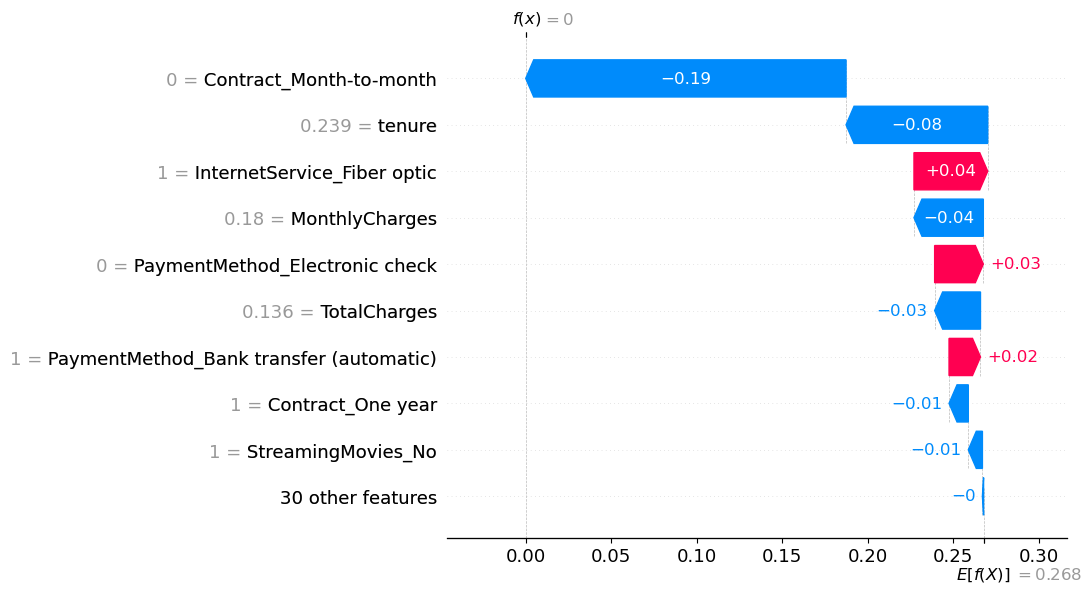

In [40]:
shap.plots.waterfall(shap_values[837])

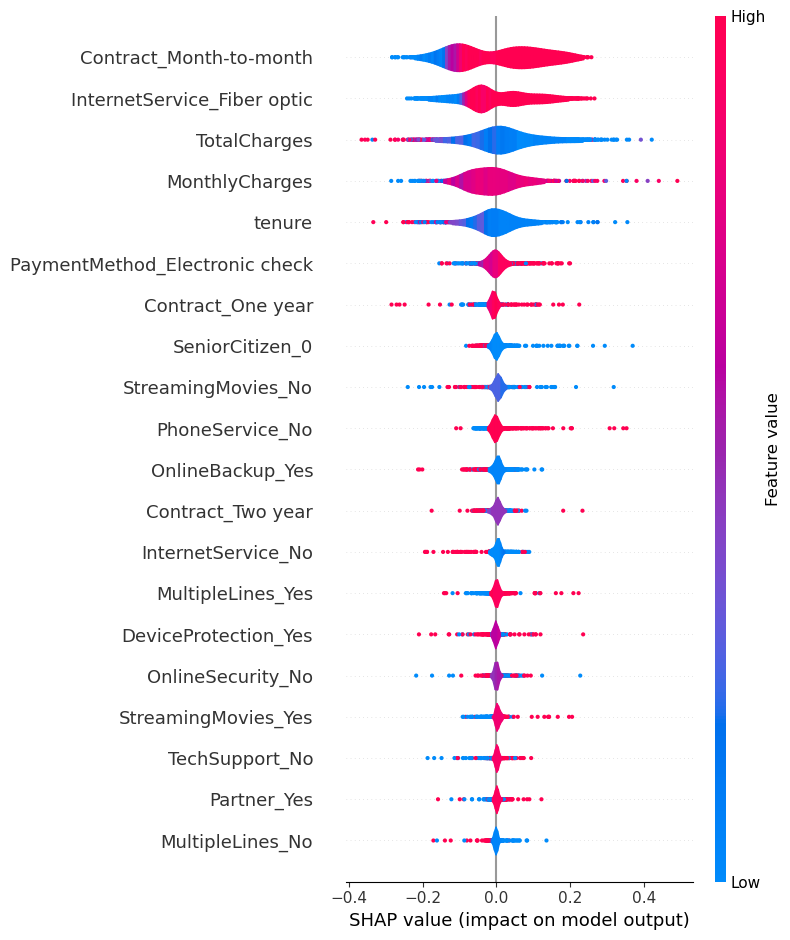

[CV 2/5] END clf__estimator=LogisticRegression(), clf__estimator__C=10, clf__estimator__max_iter=50, clf__estimator__penalty=l2; accuracy: (train=0.801, test=0.794) f1: (train=0.615, test=0.570) precision: (train=0.662, test=0.585) recall: (train=0.574, test=0.555) total time=   0.1s
[CV 1/5] END clf__estimator=LogisticRegression(), clf__estimator__C=10, clf__estimator__max_iter=100, clf__estimator__penalty=l2; accuracy: (train=0.798, test=0.811) f1: (train=0.603, test=0.614) precision: (train=0.656, test=0.632) recall: (train=0.558, test=0.598) total time=   0.1s
[CV 5/5] END clf__estimator=LogisticRegression(), clf__estimator__C=10, clf__estimator__max_iter=100, clf__estimator__penalty=l2; accuracy: (train=0.806, test=0.796) f1: (train=0.598, test=0.614) precision: (train=0.659, test=0.706) recall: (train=0.546, test=0.544) total time=   0.1s
[CV 4/5] END clf__estimator=LogisticRegression(), clf__estimator__C=10, clf__estimator__max_iter=150, clf__estimator__penalty=l2; accuracy: (tr

In [41]:
shap.summary_plot(shap_values, plot_type="violin")